In [44]:
# https://stackoverflow.com/questions/54044958/reading-data-from-a-raw-vtk-vtu-file

def vtu_extract_element_connectivity(fname):
    
    """
    Loads a vtu file, extracts the "connectivity" field and
    converts the data into a NumPy array (int64).
    The element-vertex map is returned as a 2D ndarray.
    It is assumed that all cells are of the same VTK type.
    The "offset" field in the vtu file is processed and checked to ensure that 
    all cells are the same VTK type (e.g. triangle).
    
    Parameters:
    -----------
    fname : string
      Filename of a VTU file      
    Returns:
    --------
    elmap : ndarray, shape = (ncells, npoints_per_cell)
        Element-vertex map associated with VTK cells, with dimensions (nCells, npoints_per_cell)
    """  
    import vtk as vtk

    # Read the source vtu file.
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update() # Needed because of GetScalarRange
    output = reader.GetOutput()

    cells = output.GetCells()

    offset_per_cell = cells.IsHomogeneous()
    if offset_per_cell <= 0:
        raise ValueError('Require all cells have the same size (homogeneous).')

    nCells = cells.GetNumberOfCells()
    array = cells.GetConnectivityArray()
    elmap = np.asarray(array ,dtype=np.int64)
    elmap = elmap.reshape(nCells, offset_per_cell)
    return elmap

In [45]:
def vtu_extract_fields(fname, extract_coor=True):
    """
    Extract point fields, cell fields and point coordiantes from a vtu file.
    
    Parameters:
    -----------
    extract_coor : boolean
        Flag to indicate whether you want the coordinates to be extracted.
    
    Returns:
    --------
    point_field : dict
      All point fields found. Key is the name provided in the VTU file.
    cell_field : dict
      All cell fields found. Key is the name provided in the VTU file.
    coor_field : dict
      Coordinates of the mesh. `coor_field` be empty if extract_coor = False.
      Key used is "coor".
    """
    
    import vtk as vtk
    
    point_field = {}
    cell_field = {}
    coor_field = {}
    
    # Read the source vtu file.
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update() # Needed because of GetScalarRange
    output = reader.GetOutput()

    points = output.GetPoints()
    array = points.GetData()
    xyz = np.asarray(array, dtype=np.float64)
    if extract_coor:
        coor_field["coor"] = xyz
    
    pointFields = output.GetPointData()
    
    nfields = pointFields.GetNumberOfArrays()
    print('#point fields', nfields)
    for f in range(nfields):
        print('  pointFields.name', pointFields.GetArrayName(f))
        #print('pointFields.ndof', pointFields.GetNumberOfComponents(f))
        array = pointFields.GetArray(f)
        pf = np.asarray(array, dtype=np.float64)
        point_field[ pointFields.GetArrayName(f) ] = pf
        
    #cells = output.GetCells()
    cellFields = output.GetCellData()
    nfields = cellFields.GetNumberOfArrays()
    print('#cell fields', nfields)
    for f in range(nfields):
        print('  cellFields.name', cellFields.GetArrayName(f))
        array = cellFields.GetArray(f)
        cf = np.asarray(array, dtype=np.float64)
        cell_field[ cellFields.GetArrayName(f) ] = cf
        
    return point_field, cell_field, coor_field

#point fields 1
  pointFields.name f_28
#cell fields 0
point fields found: ['f_28']
cell fields found: []


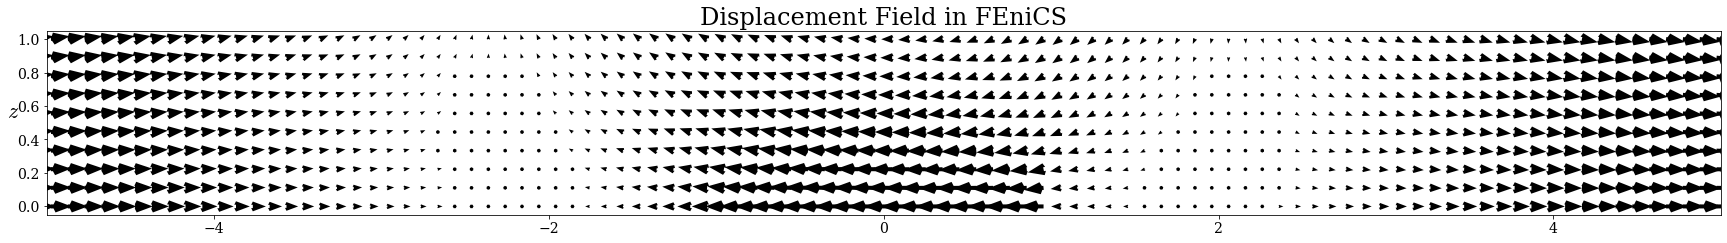

In [73]:
e2v = vtu_extract_element_connectivity("displacement000000.vtu")
pf, cf, coor = vtu_extract_fields("displacement000000.vtu")

# See what we got
pf_names = list(pf.keys())
print('point fields found:', pf_names)
cf_names = list(cf.keys())
print('cell fields found:', cf_names)

plt.rc('font', family='serif')
mpl.rcParams["mathtext.fontset"]='cm'
plt.rcParams['figure.figsize'] = (30.0, 12.0)
fs=14
########################### Figure 1 ################################
fig1, ax1 = plt.subplots()
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax1 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax1.set_ylabel(r'$z$',rotation=0,fontsize=22,loc='center')
ax1.set_xlim([-5, 5])
ax1.set_aspect('equal')
# ax1.yaxis.set_label_coords(-0.05, 0.35)
ax1.set_title('Displacement Field in FEniCS',fontsize=24)

# Interpolation
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
xi, yi = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(0, 1, 10))
interp_cubic_geom_x = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,0], kind='geom')
interp_cubic_geom_y = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,1], kind='geom')
disp_x = interp_cubic_geom_x(xi, yi)
disp_y = interp_cubic_geom_y(xi, yi)

# crack
plt.plot([w,w],[0,C], color='white')

# \sigma_{xx}
norm = mpl.colors.Normalize(vmin=-5.0e-5, vmax=5.0e-5)
cmap = mpl.cm.bwr
Q = ax1.quiver(xi, yi, disp_x, disp_y, units='width', zorder=3, headwidth=3., headlength=4.)
#Q = ax1.quiver(coor['coor'][:, 0], coor['coor'][:, 1], pf[pf_names[0]][:,0], pf[pf_names[0]][:,1], units='inches')

point fields found: ['f_28']
cell fields found: []


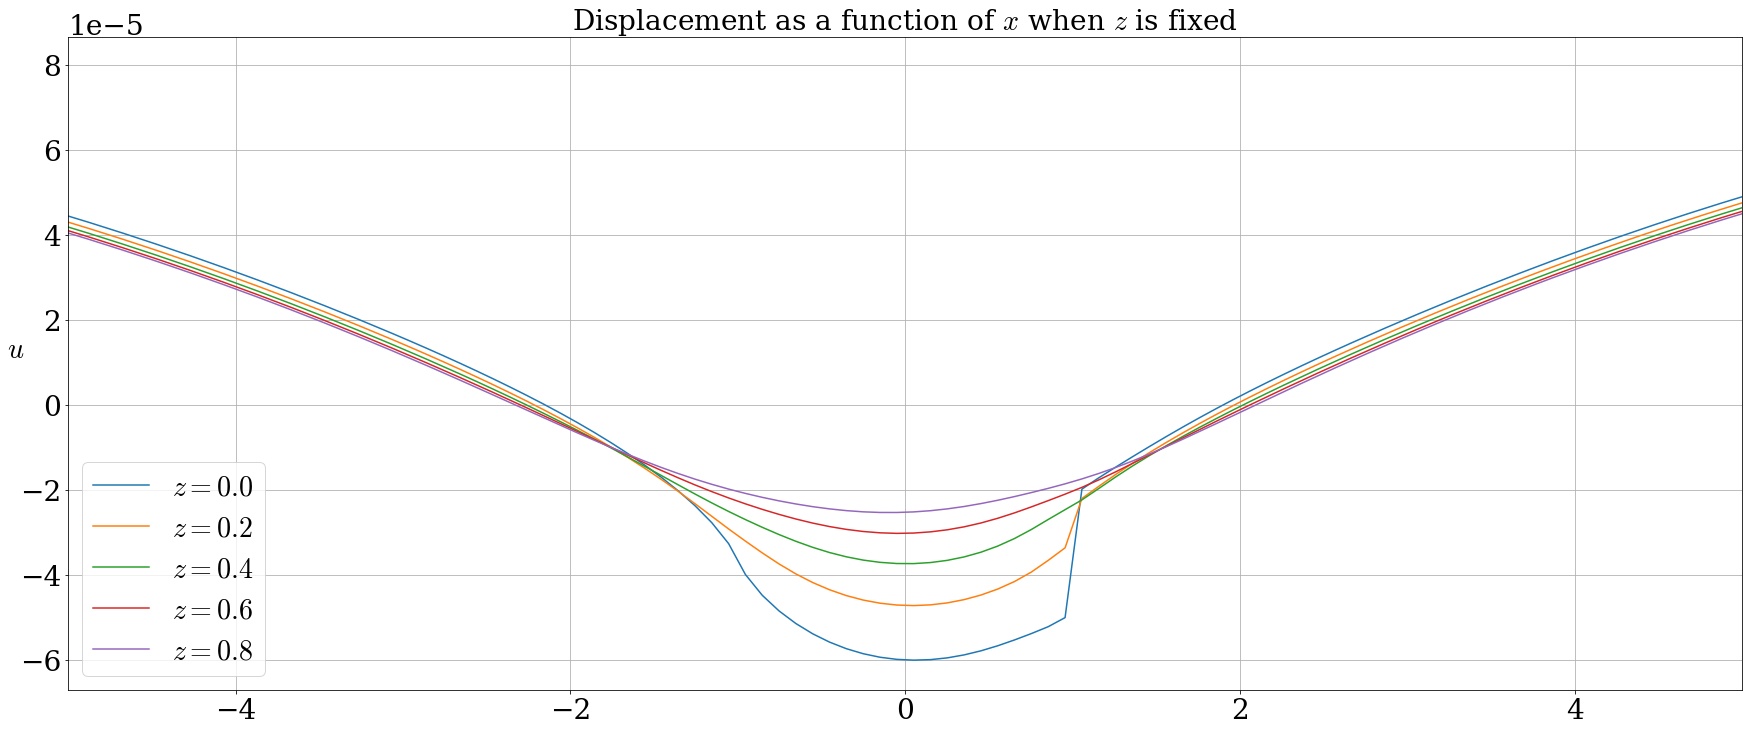

In [97]:
# See what we got
pf_names = list(pf.keys())
print('point fields found:', pf_names)
cf_names = list(cf.keys())
print('cell fields found:', cf_names)

plt.rc('font', family='serif')
mpl.rcParams["mathtext.fontset"]='cm'

fs=28
########################### Figure 1 ################################
fig1, ax1 = plt.subplots()
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)
# ax1.set_xlabel(r'$x$',fontsize=22)
ax1.set_ylabel(r'$u$',rotation=0,fontsize=fs,loc='center')
ax1.set_xlim([-5, 5])
# ax1.set_aspect('equal')
# ax1.yaxis.set_label_coords(-0.05, 0.35)
ax1.set_title('Displacement as a function of $x$ when $z$ is fixed',fontsize=fs)

# Interpolation
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
xi, yi = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(0, 1, 10))
interp_cubic_geom_x = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,0], kind='geom')
interp_cubic_geom_y = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,1], kind='geom')
disp_x = interp_cubic_geom_x(xi, yi)
disp_y = interp_cubic_geom_y(xi, yi)


# \sigma_{xx}
disp_z0 = ax1.plot(xi[0],disp_x[0],label=r'$z=0.0$')
disp_z2 = ax1.plot(xi[0],disp_x[2],label=r'$z=0.2$')
disp_z4 = ax1.plot(xi[0],disp_x[4],label=r'$z=0.4$')
disp_z6 = ax1.plot(xi[0],disp_x[6],label=r'$z=0.6$')
disp_z8 = ax1.plot(xi[0],disp_x[8],label=r'$z=0.8$')

plt.grid()
plt.legend(fontsize=fs)

#point fields 1
  pointFields.name f_65
#cell fields 0
point fields found: ['f_65']
cell fields found: []


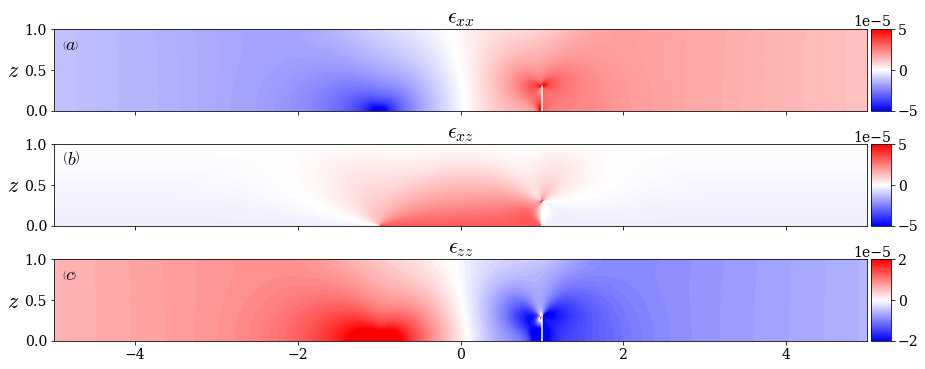

In [68]:
e2v = vtu_extract_element_connectivity("strain000000.vtu")
pf, cf, coor = vtu_extract_fields("strain000000.vtu")

# See what we got
pf_names = list(pf.keys())
print('point fields found:', pf_names)
cf_names = list(cf.keys())
print('cell fields found:', cf_names)


plt.rc('font', family='serif')
mpl.rcParams["mathtext.fontset"]='cm'
plt.rcParams['figure.figsize'] = (15.0, 6.0)
fs=14
########################### Figure 1 ################################
ax1 = plt.subplot(311)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax1 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax1.set_ylabel(r'$z$',rotation=0,fontsize=22,loc='center')
ax1.set_xlim([-5, 5])
ax1.set_aspect('equal')
ax1.yaxis.set_label_coords(-0.05, 0.35)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_title(r'$\epsilon_{xx}$',fontsize=22)

# plt.title(r'$\sigma_{xx}$ when $w=1$, $c=0.5$, $f=0.7$', fontsize=16, color='k')
plt.annotate(r'$\left(a\right)$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=18)
# crack
plt.plot([w,w],[0,C], color='white')

# \sigma_{xx}
norm = mpl.colors.Normalize(vmin=-5.0e-5, vmax=5.0e-5)
cmap = mpl.cm.bwr
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,0], levels=1000, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

########################### Figure 2 ################################
ax2 = plt.subplot(312, sharex=ax1)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax2 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax2.set_ylabel(r'$z$',rotation=0,fontsize=22,loc='center')
ax2.set_xlim([-5, 5])
ax2.set_aspect('equal')
ax2.yaxis.set_label_coords(-0.05, 0.35)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_title(r'$\epsilon_{xz}$',fontsize=22)

# plt.title(r'$\sigma_{xx}$ when $w=1$, $c=0.5$, $f=0.7$', fontsize=16, color='k')
plt.annotate(r'$\left(b\right)$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=18)


# \sigma_{xx}
norm = mpl.colors.Normalize(vmin=-5.0e-5, vmax=5.0e-5)
cmap = mpl.cm.bwr
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,1], levels=1000, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

########################### Figure 2 ################################
ax3 = plt.subplot(313, sharex=ax1)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax3 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax3.set_ylabel(r'$z$',rotation=0,fontsize=22,loc='center')
ax3.set_xlim([-5, 5])
ax3.set_aspect('equal')
ax3.yaxis.set_label_coords(-0.05, 0.35)
plt.annotate(r'$\left(c\right)$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=18)
# crack
plt.plot([w,w],[0,C], color='white')
ax3.set_title(r'$\epsilon_{zz}$',fontsize=22)

norm = mpl.colors.Normalize(vmin=-2.0e-5, vmax=2.0e-5)
cmap = mpl.cm.bwr
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,4], levels=900, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, format="%2.1f")